<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="3"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>WinnER: A Winner-Take-All Hashing-Based Unsupervised Model <br>for Entity Resolution Problems<br></b> 
    </font>
     <hr>
     <font size="4">
        Study on CORA data set 
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos</b>, BS Student at NKUA 
     </font>
</div>
<div align="center"> 
    <font size="4">
     <b> Alex Delis</b>,  Professor NKUA <br> 
     <b> Vassilios Verykios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Code injection__

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx
import itertools 
import sklearn
import plotly.express as px
import logging
import sys
import optuna
import plotly

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

# plt.style.use('seaborn-white') # plot style

Automated refresh on the notebook

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Main model dependency

In [3]:
from model import WinnER, customClassificationReport, report, set_params

## Utilities

In [4]:
from utils.mmd2 import MMD2, myMMD2
from plot.heatmap import myHeatmap
from plot.confusion_matrix import create_ConfusionMatrix
from plot.dimension_reduction import SpaceVisualization2D, SpaceVisualization3D, SpaceVisualizationEmbeddings2D, SpaceVisualizationEmbeddings3D
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Dataset utils

In [5]:
from datasets.common.create_dataset import createDataset, createTrueLabels
from utils.grid_search import GridSearch

### Custom metrics

In [7]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo


# __Dataset injection__

## Load data from Drive in Colab

In [8]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

### JedAI Dirty datasets

#### CORA

In [54]:
CORA_groundTruth = os.path.abspath("../data/coraIdDuplicates.csv")
CORA = os.path.abspath("../data/coraProfiles.csv")
CORA_groundTruth = pd.read_csv(CORA_groundTruth, sep = '|', header = None, names = ['id1','id2'])
CORA_groundTruth=CORA_groundTruth.sort_values(by = ['id1','id2'], ignore_index = True)
CORA = pd.read_csv(CORA, sep = '|')
# CORA

In [10]:
# CORA_groundTruth.head(10)

#### CENSUS

In [11]:
CENSUS_groundTruth = os.path.abspath("../data/censusIdDuplicates.csv")
CENSUS = os.path.abspath("../data/censusProfiles.csv")
CENSUS_groundTruth = pd.read_csv(CENSUS_groundTruth,sep='|',header=None,names=['id1','id2'])
CENSUS = pd.read_csv(CENSUS,sep='|')
# CENSUS

In [12]:
# CENSUS_groundTruth

#### CDDB

In [13]:
CDDB_groundTruth = os.path.abspath("../data/cddbIdDuplicates.csv")
CDDB = os.path.abspath("../data/cddbProfiles.csv")
CDDB_groundTruth = pd.read_csv(CDDB_groundTruth,sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(CDDB,sep='/00000',engine='python')
# CDDB

In [14]:
# CDDB_groundTruth

#### DBLP - ACM

In [15]:
ACM = os.path.abspath("../data/ACM.csv")
DBLP = os.path.abspath("../data/DBLP2.csv")
ACM_DBLP_trueValues = os.path.abspath("../data/DBLP-ACM_perfectMapping.csv")
ACM = pd.read_csv(ACM)
DBLP = pd.read_csv(DBLP, encoding='latin-1')
ACM_DBLP_trueValues = pd.read_csv(ACM_DBLP_trueValues)

#### CORA - 1st edition

In [16]:
fpcora = os.path.abspath("../data/cora1stEdition/CORA.xml")
fpcora_gold = os.path.abspath("../data/cora1stEdition/cora_gold.csv")
CORA1 = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
CORA1['@id'] = pd.to_numeric(CORA1['@id']).subtract(1)
CORA1_groundTruth = pd.read_csv(fpcora_gold,sep=';')
CORA1_groundTruth['id1'] = pd.to_numeric(CORA1_groundTruth['id1']).subtract(1)
CORA1_groundTruth['id2'] = pd.to_numeric(CORA1_groundTruth['id2']).subtract(1)

# __Dataset attribute analysis__

In [17]:
DATASET_NAME = 'CORA'

## Data set shuffle (Optional)

In [18]:
CORA_shuffled = CORA.sample(frac=1).reset_index(drop=True)
# CORA_shuffled

## Pre-process

In [19]:
fields = [
     'address',
     'author',
     'editor',
     'institution',
     'month',
     'note',
     'pages',
     'publisher',
     'title',
     'venue',
     'volume',
     'year',
     'Unnamed: 13'
]

# fields = [
#      'author',
#      'title',
# ]


# CORA
data, true_matrix = createDataset(CORA, CORA_groundTruth, fields, 'Entity Id')

# Toy CORA
# data, true_matrix = createDataset(CORA.head(15), CORA_groundTruth.head(50), fields, 'Entity Id')

# Old CORA
# data, true_matrix = createDataset(CORA1, CORA1_groundTruth, fields, '@id')

Creating dataset from imput files:   0%|          | 0/1295 [00:00<?, ?it/s]

Creating groundtruth matrix:   0%|          | 0/17184 [00:00<?, ?it/s]

__Clique construction for visualization purposes__

In [20]:
labels_groundTruth, numOfObjWithoutDups, groups = createTrueLabels(CORA['Entity Id'].tolist(),CORA_groundTruth)            
data_length = [ len(x) for x in data ]

## Attributes

In [21]:
specs = {
    'Objects without any duplicates' : CORA.shape[0] - sum([len(x) for x in groups]), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : CORA.shape[0], 
    'Mean size of clusters' : np.average([len(x) for x in groups]),
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length),
    'Median length' : np.median(data_length)
}
specsCoraDf = pd.DataFrame(list(specs.items()), columns=['Spec','#count'])
specsCoraDf[['#count']] = specsCoraDf[['#count']].astype(int)
specsCoraDf

Spec  #count
0       Objects without any duplicates      19
1  Objects with at least one duplicate    1276
2              Total number of objects    1295
3                Mean size of clusters      13
4                Number of ER clusters      93
5                         Dataset size    1295
6                       Average length     164
7                           Min length      38
8                           Max length     366
9                        Median length     164

In [22]:
list(CORA.columns)

['Entity Id',
 'address',
 'author',
 'editor',
 'institution',
 'month',
 'note',
 'pages',
 'publisher',
 'title',
 'venue',
 'volume',
 'year',
 'Unnamed: 13']

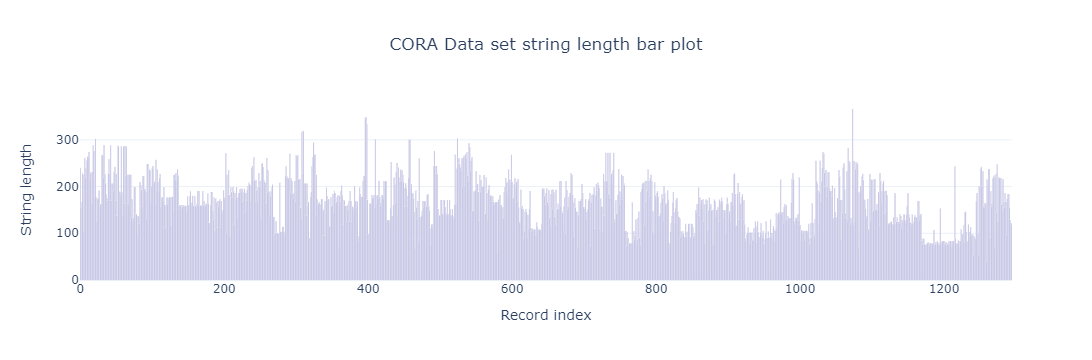

In [23]:
df = pd.DataFrame({"Record index":range(0,len(data_length),1),"String length":data_length})
fig = px.bar(df, x= "Record index", y="String length", title= DATASET_NAME + " Data set string length bar plot",template='plotly_white')
fig.update_traces(marker_color='darkblue', opacity=1.0)
fig.update_layout(title_x=0.5)
fig.show()

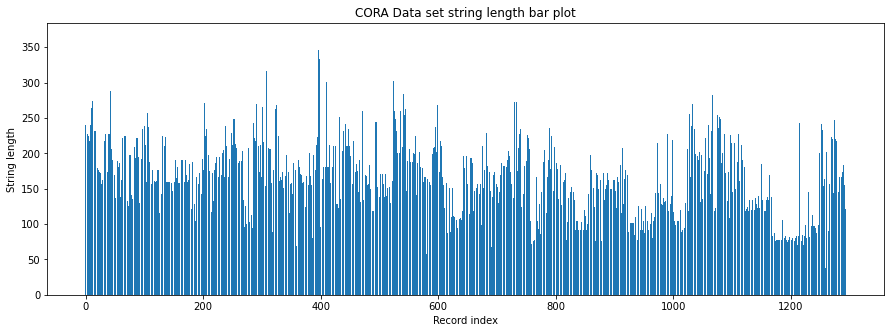

In [24]:
fig = plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title(DATASET_NAME + " Data set string length bar plot")
fig.savefig("strlenncora.png")
plt.show()

# Optuna studies

## Euclid-Jaccard with 2-grams and char-tokenization

## Euclid-Jaccard with 3-grams and char-tokenization

In [28]:
euclid_jaccard_char_3_CORA = optuna.create_study(
    directions = ["maximize"],
    study_name = "euclid_jaccard_char_3_CORA", 
    storage    = "sqlite:///optuna_tuning/WinnER_Experiments_v2.db", 
    load_if_exists = True
)

[I 2022-02-12 14:44:52,476] Using an existing study with name 'euclid_jaccard_char_3_CORA' instead of creating a new one.


Trials dataframe (Optuna default)

In [29]:
euclid_jaccard_char_3_CORA.trials_dataframe(attrs=("number", "value", "params", "state"))

number      value  params_max_dissimilarity_distance  \
0        0  70.874069                           0.262621   
1        1  65.555168                           0.569708   
2        2  65.392225                           0.313881   
3        3  71.362896                           0.485946   
4        4  69.419227                           0.409344   
..     ...        ...                                ...   
95      95  71.665503                           0.187927   
96      96  73.533520                           0.148478   
97      97  75.192039                           0.252751   
98      98  75.512104                           0.167393   
99      99  75.442272                           0.188359   

    params_max_num_of_clusters  params_number_of_permutations  \
0                          668                              4   
1                          427                              5   
2                          693                              2   
3                          469                              5   
4                          638                              4   
..                         ...                            ...   
95                         290                              5   
96                         237                              5   
97                         332                              5   
98                         407                              5   
99                         382                              5   

    params_similarity_threshold  params_window_size     state  
0                      0.568667                  96  COMPLETE  
1                      0.639243                  74  COMPLETE  
2                      0.613330                 100  COMPLETE  
3                      0.569261                  96  COMPLETE  
4                      0.603897                  90  COMPLETE  
..                          ...                 ...       ...  
95                     0.559904                  35  COMPLETE  
96                     0.555142                  32  COMPLETE  
97                     0.567884                  39  COMPLETE  
98                     0.572389                  42  COMPLETE  
99                     0.554725                  35  COMPLETE  

[100 rows x 8 columns]

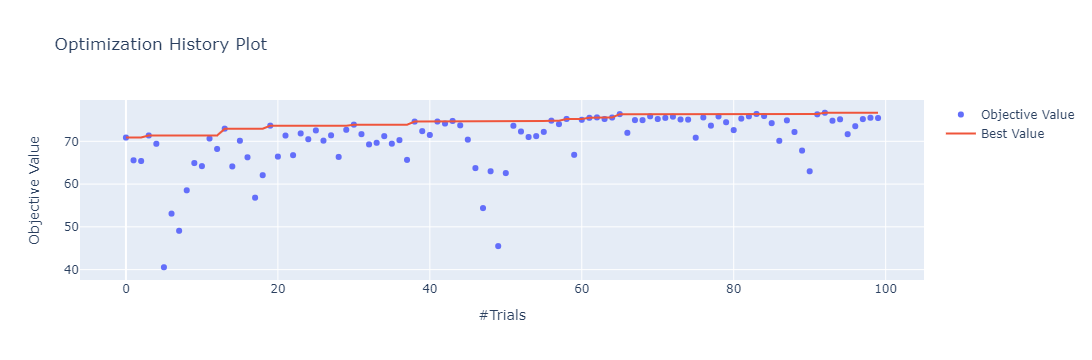

In [31]:
plot_optimization_history(euclid_jaccard_char_3_CORA)

[W 2022-02-12 14:46:07,336] You need to set up the pruning feature to utilize `plot_intermediate_values()`


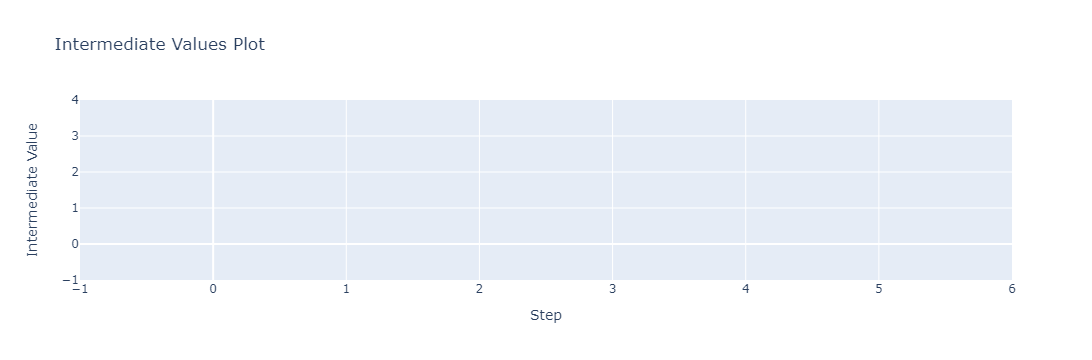

In [32]:
plot_intermediate_values(euclid_jaccard_char_3_CORA)

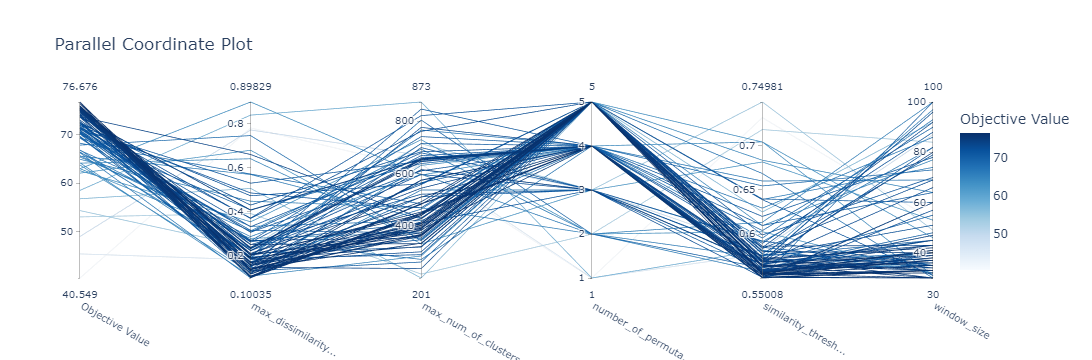

In [33]:
plot_parallel_coordinate(euclid_jaccard_char_3_CORA)

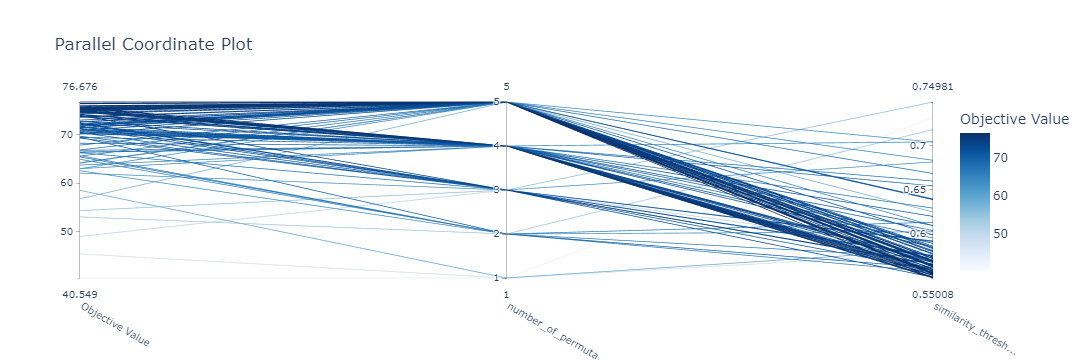

In [34]:
plot_parallel_coordinate(euclid_jaccard_char_3_CORA, params=["number_of_permutations", "similarity_threshold"])

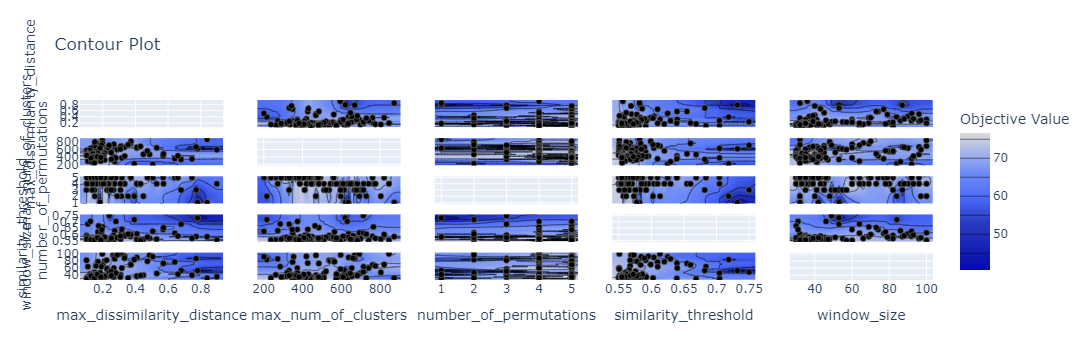

In [35]:
plot_contour(euclid_jaccard_char_3_CORA)

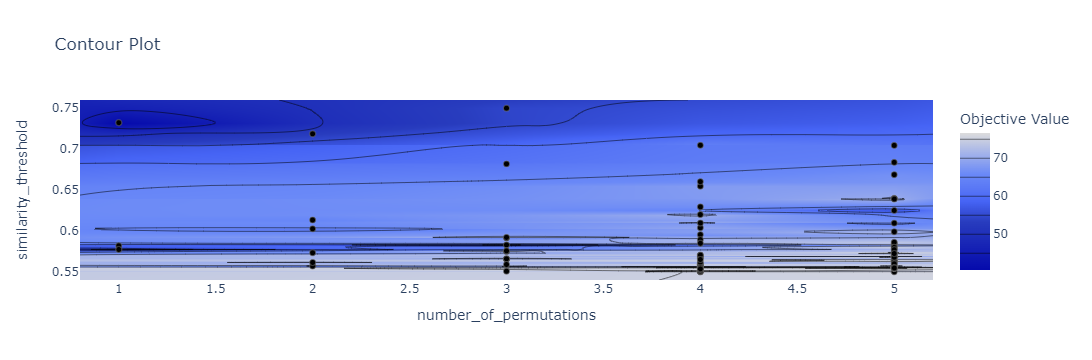

In [37]:
plot_contour(euclid_jaccard_char_3_CORA, params=["number_of_permutations", "similarity_threshold"])

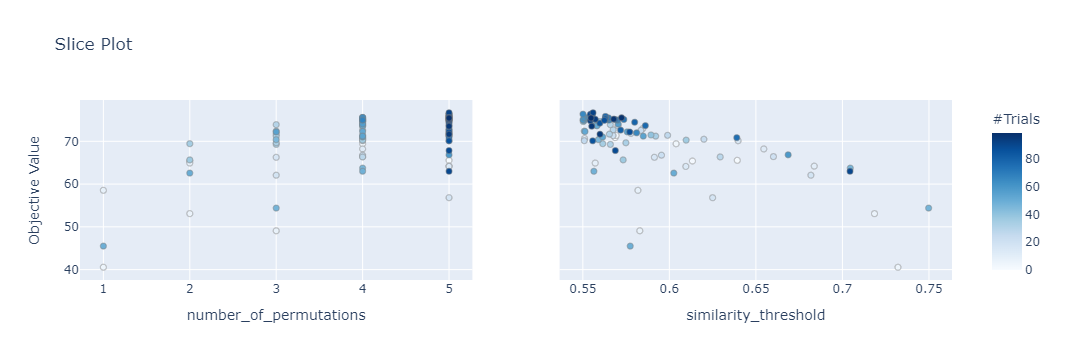

In [38]:
plot_slice(euclid_jaccard_char_3_CORA,  params=["number_of_permutations", "similarity_threshold"])

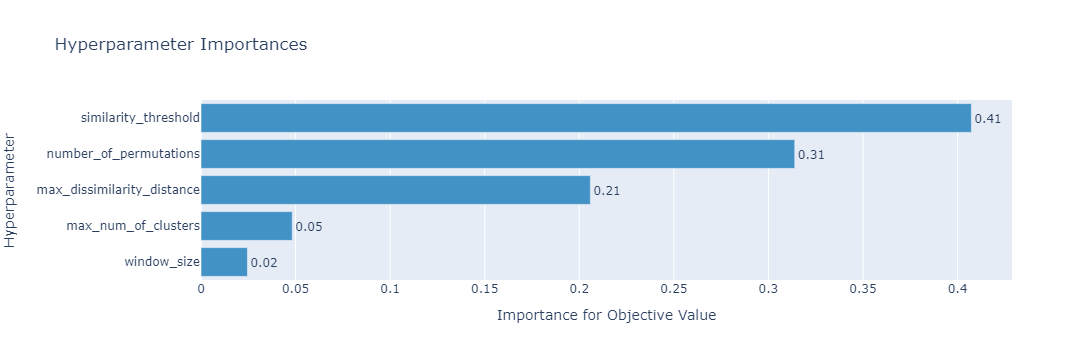

In [39]:
plot_param_importances(euclid_jaccard_char_3_CORA)

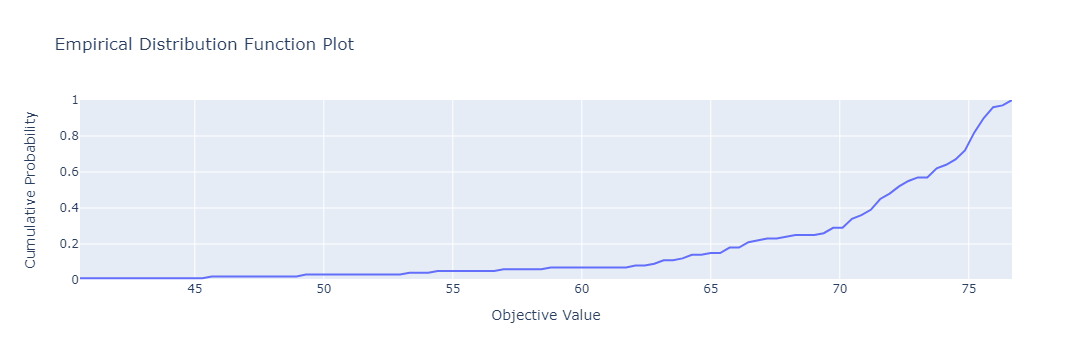

In [40]:
plot_edf(euclid_jaccard_char_3_CORA)

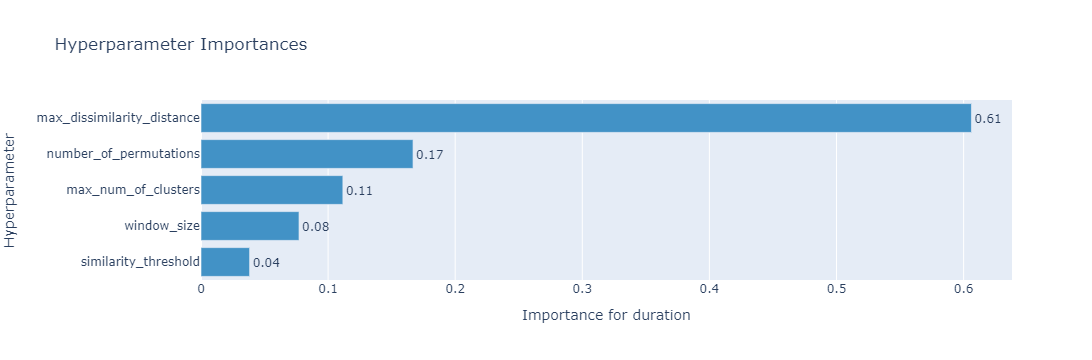

In [47]:
optuna.visualization.plot_param_importances(
    euclid_jaccard_char_3_CORA, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

### Study statistics

In [52]:
euclid_jaccard_char_3_CORA_DF = pd.read_csv(
    os.path.abspath("./optuna_tuning/csv/euclid_jaccard_char_3_CORA.csv")
)
print(euclid_jaccard_char_3_CORA_DF.columns)

Index(['trial_id', 'max_num_of_clusters', 'max_dissimilarity_distance',
       'similarity_threshold', 'window_size', 'metric', 'similarity_vectors',
       'embedding_distance_metric', 'distance_metric',
       'number_of_permutations', 'ngramms', 'char_tokenization',
       'num_of_comparisons', 'diffObjectsComparedSuccess',
       'sameObjectsCompared', 'sameObjectsComparedSuccess',
       'selection_variance', 'selectedNumOfPrototypes', 'averageBucketSize',
       'prototypesTime', 'embeddingsTime', 'wtaTime', 'similarityTime',
       'Accuracy', 'Precision', 'Recall', 'F1', 'Time'],
      dtype='object')


In [50]:
euclid_jaccard_char_3_CORA_DF.sort_values(by=['Recall','F1'])

trial_id  max_num_of_clusters  max_dissimilarity_distance  \
5          5                  620                    0.780514   
49        49                  636                    0.183208   
7          7                  669                    0.771488   
6          6                  216                    0.392782   
47        47                  714                    0.239096   
..       ...                  ...                         ...   
84        84                  334                    0.141559   
91        91                  401                    0.138377   
65        65                  445                    0.107723   
83        83                  365                    0.190666   
92        92                  392                    0.141549   

    similarity_threshold  window_size  metric similarity_vectors  \
5               0.732096           53  kendal            initial   
49              0.577381           42  kendal            initial   
7               0.582914           87  kendal            initial   
6               0.718535           84  kendal            initial   
47              0.749814           49  kendal            initial   
..                   ...          ...     ...                ...   
84              0.555513           41  kendal            initial   
91              0.554353           37  kendal            initial   
65              0.550083           33  kendal            initial   
83              0.555192           41  kendal            initial   
92              0.555891           37  kendal            initial   

   embedding_distance_metric distance_metric  number_of_permutations  ...  \
5             euclid_jaccard  euclid_jaccard                       1  ...   
49            euclid_jaccard  euclid_jaccard                       1  ...   
7             euclid_jaccard  euclid_jaccard                       3  ...   
6             euclid_jaccard  euclid_jaccard                       2  ...   
47            euclid_jaccard  euclid_jaccard                       3  ...   
..                       ...             ...                     ...  ...   
84            euclid_jaccard  euclid_jaccard                       5  ...   
91            euclid_jaccard  euclid_jaccard                       5  ...   
65            euclid_jaccard  euclid_jaccard                       5  ...   
83            euclid_jaccard  euclid_jaccard                       5  ...   
92            euclid_jaccard  euclid_jaccard                       5  ...   

    averageBucketSize  prototypesTime  embeddingsTime   wtaTime  \
5                  28        6.183494        2.606617  0.032039   
49                 23        6.366437       20.249249  0.130996   
7                  78        5.735587        2.717997  0.111000   
6                  58        0.889003        5.702631  0.100000   
47                 64        8.163794       22.831679  0.462001   
..                ...             ...             ...       ...   
84                114        1.839006       11.363129  0.378030   
91                101        2.909432       15.374219  0.457998   
65                101        3.317637       14.895957  0.527009   
83                116        2.399000       12.790550  0.396968   
92                 97        2.487664       12.938630  0.427998   

    similarityTime   Accuracy  Precision     Recall         F1        Time  
5        45.274442  98.523404  76.211309  40.549348  52.934250   54.852664  
49       69.085166  97.339721  37.629958  45.495810  41.190727   96.621847  
7        65.129571  96.468731  28.766843  49.074721  36.271748   74.451188  
6       106.021767  98.186043  56.024318  53.090084  54.517748  113.429401  
47      185.353099  98.709781  75.772318  54.381983  63.319443  217.526613  
..             ...        ...        ...        ...        ...         ...  
84      252.648119  93.968135  21.914954  75.907821  34.010821  266.922288  
91      242.019952  93.777706  21.406533  76.309358  33.4340

# Best model

In [53]:
euclid_jaccard_char_3_CORA.best_params

{'max_dissimilarity_distance': 0.14154910884900634,
 'max_num_of_clusters': 392,
 'number_of_permutations': 5,
 'similarity_threshold': 0.5558910180622564,
 'window_size': 37}

In [ ]:
bestModel = set_params(euclid_jaccard_char_3_CORA.best_params)
bestModel.hackForDebug(labels_groundTruth, true_matrix)
bestModel = bestModel.fit(data)
acc,f1,precision,recall = bestModel.evaluate(bestModel.mapping_matrix, true_matrix)


#####################################################################
#                           .~  WinnER  ~.                          #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


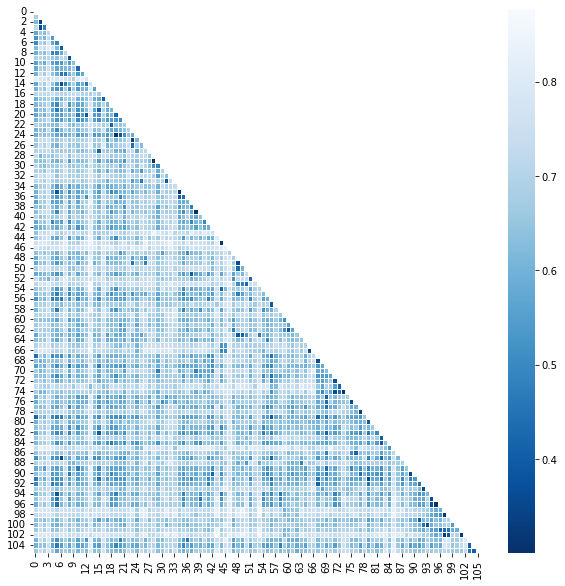


- Mean variance in prototype selection:  0.6554776228470893

- Final number of prototypes:  106

# Finished in 164467 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


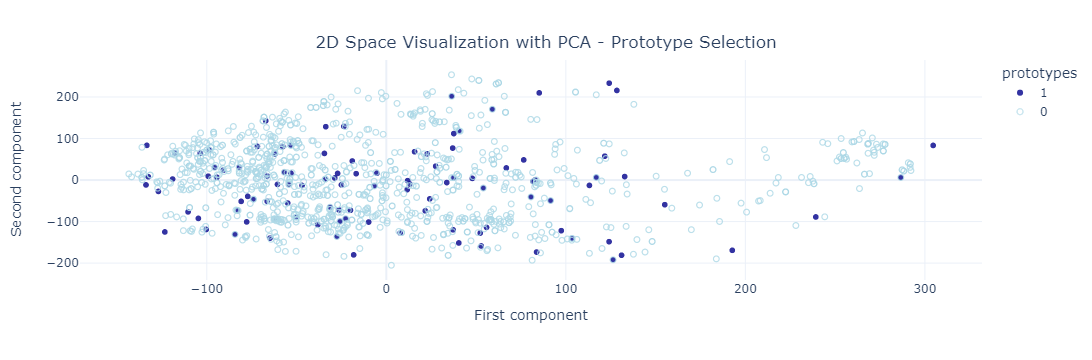


# Finished in 164467 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:

- WTA number of buckets:  13


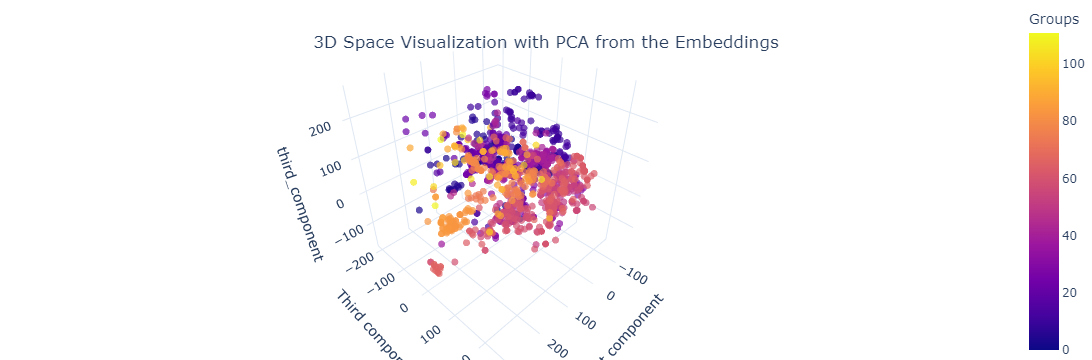


# Finished in 164467 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:
Total comparisons:  182340
 -> between same objects:  11130
 -> between same objects with success:  8361
 -> between different objects:  171210
 -> between different objects with success:  165364

# Finished in 164467 secs

#####################################################################
#                           .~  End  ~.                             #
#####################################################################

#####################################################################
#                          Evaluation                               #
#####################################################################

Accuracy:  98.25 %
F1-Score:  53.27 %
Recall:    48.66 %
Precision: 58.85 %


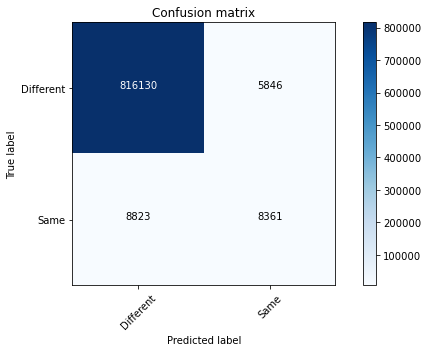

In [48]:
model = WinnER(
    max_num_of_clusters = 400,
    max_dissimilarity_distance = 0.3,
    window_size = 50,
    similarity_threshold = 0.65,
    metric = 'kendal',
    similarity_vectors = 'initial',
    number_of_permutations = 1,
    distance_metric= 'jaccard',
    embedding_distance_metric = 'jaccard',
    ngrams = 2,
    char_tokenization = True,
    verbose_level = 1,
    disable_tqdm = True
)
model.hackForDebug(labels_groundTruth, true_matrix)
model = model.fit(data)
acc,f1,precision,recall = model.evaluate(model.mapping_matrix, true_matrix)

## Space Visualization

In [ ]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray, withPlotly=False)

In [ ]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray)

In [ ]:
SpaceVisualization2D(model.Embeddings, model.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(model.Embeddings, model.prototypeArray)

In [ ]:
SpaceVisualization3D(model.rankedVectors,model.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(model.rankedVectors, model.prototypeArray, withPlotly = False, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(model.rankedVectors, model.prototypeArray, withPlotly = True, decompositionMenthod='MDS')

In [ ]:
SpaceVisualizationEmbeddings2D(
    model.Embeddings, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    model.rankedVectors, labels_groundTruth, withPlotly=False, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    model.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    model.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='MDS'
)

__MMD error between distribution of Prototypes and whole Dataset__

In [33]:
myMMD2(model)

MMD2:  -0.017917345658945538
